# CH02.1. **Training Utility - Scheduler**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 1000
USE_PRETRAIN_YN = 'N'
MODEL_PTH = '../../model/bostonRegScheduler.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch
import torchinfo

#(2) Set up options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Set up device
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

>> Device : mps


#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `describe_df()` function
def describe_df(df:pd.DataFrame) -> pd.DataFrame :
    output = pd.DataFrame(data={
        'dataType'     : df.dtypes,
        'nullCount'    : df.isnull().sum(),
        'nonNullCount' : (df.shape[0]-df.isnull().sum()),
        'uniqueCount'  : df.nunique()
    })
    return output

#(2) Define `compute_rmse()` function
def compute_rmse(model:torch.nn.Module, loader:torch.utils.data.DataLoader) -> int :
    model.eval()
    with torch.no_grad() : 
        square_sum = 0
        instance_num = 0
        for inputs, targets in loader :
            preds = model(x=inputs)
            square_sum += torch.sum(
                input=(preds-targets.to(device=preds.device))**2
            ).item()
            instance_num += len(targets)
    model.train()
    output = np.sqrt(square_sum/instance_num)
    return output

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `MyTensorDataset` class
class MyTensorDataset(torch.utils.data.Dataset) :
    def __init__(self, df:pd.DataFrame, pred_label_nm:'str', data_type:torch.dtype=torch.float32) :
        self.feature = torch.tensor(data=df.drop(labels=pred_label_nm, axis=1).values, dtype=data_type)
        self.label = torch.tensor(data=df.loc[:, pred_label_nm].values, dtype=data_type).reshape(shape=(-1, 1))
        self.len = self.label.shape[0]
    def __getitem__(self, index) :
        return self.feature[index], self.label[index]
    def __len__(self) :
        return self.len

#(2) Define `MyRegressionModel` class
class MyRegressionModel(torch.nn.Module) :
    def __init__(self, input_shape:tuple, hidden_dims:list, device:torch.device) :
        super().__init__()
        self.device = device
        dims = [input_shape[0]] + hidden_dims
        for i in range(len(hidden_dims)):
            self.add_module(
                name=f'fc_block_{i}',
                module=torch.nn.Sequential(
                    torch.nn.Linear(in_features=dims[i], out_features=dims[i+1]),
                    torch.nn.BatchNorm1d(num_features=dims[i+1]),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(p=0.2)
                )
            )
        self.add_module(
            name=f'fc_block_{i+1}', 
            module=torch.nn.Sequential(
                torch.nn.Linear(in_features=dims[-1], out_features=input_shape[1])
            )
        )
        self.to(device=device)
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        x = x.to(device=self.device)
        for block in self._modules.values():
            x = block(x)
        return x

<b></b>

## 01. **학습 보조기능 - 학습률 스케줄러(Learning Rate Scheduler)**

#### (1) **정의** : **[CONTENTS]**

<b></b>

## 02. **데이터셋 로드 및 전처리**

In [5]:
#(1) 
boston_raw = pd.read_csv(filepath_or_buffer='../../data/boston.csv', index_col=[0])

#(2)
boston_train, boston_test = sklearn.model_selection.train_test_split(boston_raw, train_size=0.7, random_state=SEED_NUM)

#(3)
boston_train = MyTensorDataset(df=boston_train, pred_label_nm='Price', data_type=torch.float32)
boston_test = MyTensorDataset(df=boston_test, pred_label_nm='Price', data_type=torch.float32)

#(4)
boston_train_loader = torch.utils.data.DataLoader(dataset=boston_train, batch_size=BATCH_SIZE, shuffle=True)
boston_test_loader = torch.utils.data.DataLoader(dataset=boston_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 03. **모델 구축 및 학습**

#### 03.1. **모델 정의**

In [6]:
#(1) Define `model`
model = MyRegressionModel(input_shape=(13, 1), hidden_dims=[128, 64, 32], device=device)

#(2) Print `model`
# torchinfo.summary(
#     model=model, 
#     input_size=[BATCH_SIZE]+list(boston_train[0][0].shape),
#     device=device
# )

In [7]:
#(3) Define loss function
criterion = torch.nn.MSELoss()

#(4) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-7)

#(5) Define Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 03.2. **모델 체크포인트 로드**

In [8]:
batch_len = len(boston_train_loader)
if USE_PRETRAIN_YN == 'Y' :
    checkpoint = torch.load(f=MODEL_PTH, map_location=device)
    model.load_state_dict(state_dict=checkpoint['model'])
    optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = loss_hist[-1]
else :
    epoch = 0
    loss_hist = []
    best_loss = float('inf')
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=0, Train Loss=inf


#### 03.3. **모델 학습**

In [ ]:
progress_bar = tqdm.trange(epoch, EPOCH_NUM)
for epoch in progress_bar : 
    last_loss = 0.0
    model.train()
    for inputs, targets in boston_train_loader :
        optimizer.zero_grad() 
        preds = model(x=inputs)
        loss = criterion(input=preds, target=targets.to(device=device))
        loss.backward()
        optimizer.step()
        last_loss += loss.item()
    last_loss_avg = last_loss / batch_len
    loss_hist.append(last_loss_avg)
    if last_loss_avg < best_loss :
        best_epoch = epoch
        best_loss = last_loss_avg
        torch.save(
            obj={
                'epoch'     : epoch,
                'loss_hist' : loss_hist,
                'model'     : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, 
            f=MODEL_PTH
        )
    scheduler.step()  # update scheduler
    progress_bar.set_postfix(ordered_dict={'last_epoch':epoch+1, 'last_loss':last_loss_avg, 'best_epoch':best_epoch, 'best_loss':best_loss})

100%|██████████| 1000/1000 [02:12<00:00,  7.57it/s, epoch=1000, last_loss=0.0188, best_loss=0.013]


<b></b>

## 04. **모델 평가**

#### 04.1. **최적 성능 모델 로드**

In [ ]:
checkpoint = torch.load(f=MODEL_PTH, map_location=device)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Best Epoch : {checkpoint["epoch"]}, Best Loss : {checkpoint["loss_hist"][-1]}')

>> Epoch : 943, Loss : 0.012989842798560858


#### 04.2. **과소 적합 확인**

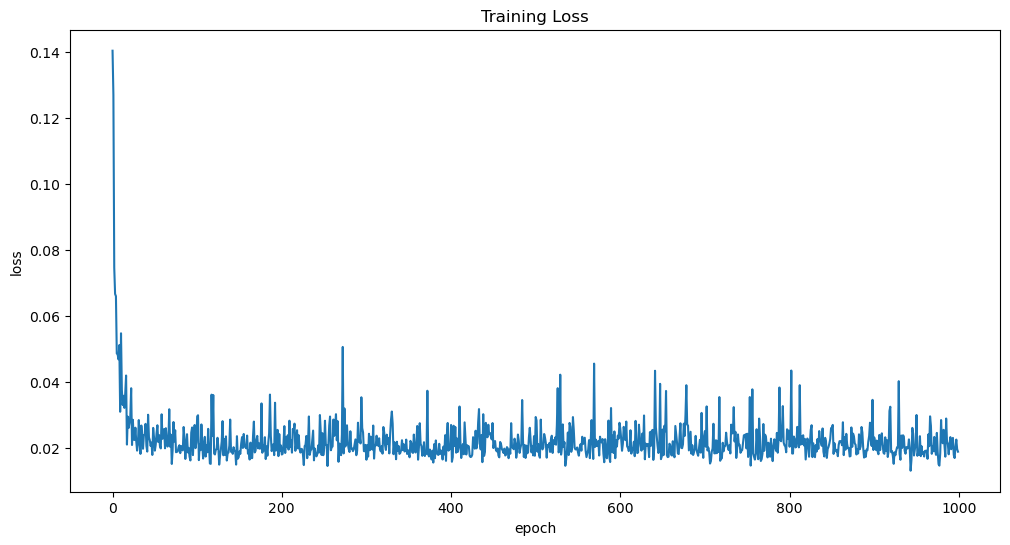

In [11]:
#(1) Plot traing loss
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

In [12]:
#(2) Check RMSE
rmse_train = compute_rmse(model=model, loader=boston_train_loader)
print(f'>> Train RMSE: {rmse_train}')

>> Train RMSE: 0.10066456956917738


#### 04.3. **일반화 성능 평가**

In [13]:
rmse_test = compute_rmse(model=model, loader=boston_test_loader)
print(f'>> Test RMSE : {rmse_test}')

>> Test RMSE : 0.10783317347338624
